In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

index_prices = pd.read_csv('sphist.csv')

#converting Date column into datetime data
index_prices['Date'] = pd.to_datetime(index_prices['Date'])
#sorting dataframe by Date column
index_prices = index_prices.sort_values(by=['Date']).reset_index(drop=True)

In [2]:
index_prices.shape

(16590, 7)

The dataset is time sensitive, meaning that the observations are not independent. The upside is that we can generate indiators to make the model more accurate, incroporating information from multiple prior rows into one. We will make four categories of indicators and use these as our features.

# Average Indicators

In [3]:
#average price from the past 5 days
index_prices['day_5'] = index_prices['Close'].rolling(window=5).mean().shift(1)
#average price form the past 30 days
index_prices['day_30'] = index_prices['Close'].rolling(window=30).mean().shift(1)
#average price for the past 365 days
index_prices['day_365'] = index_prices['Close'].rolling(window=365).mean().shift(1)

# Average Ratio Indicators

In [4]:
#the ratio between the average price for the past 5 days, and the average price for the past 365 days
index_prices['ratio_5_to_365'] = index_prices['day_5'] / index_prices['day_365']
#between 30 days and 365 days
index_prices['ratio_30_to_365'] = index_prices['day_30'] / index_prices['day_365']
#between 5 days and 30 days
index_prices['ratio_5_to_30'] = index_prices['day_5'] / index_prices['day_30']

# Standard Deviation Indicators

In [5]:
#standard deviation of price from the past 5 days
index_prices['day_5_std'] = index_prices['Close'].rolling(window=5).std().shift(1)
#standard deviation of price form the past 30 days
index_prices['day_30_std'] = index_prices['Close'].rolling(window=30).std().shift(1)
#standard deviation of price for the past 365 days
index_prices['day_365_std'] = index_prices['Close'].rolling(window=365).std().shift(1)

# Standard Deviation Ratio Indicators

In [6]:
#the ratio between the standard deviation of price for the past 5 days, and the standard deviation price for the past 365 days
index_prices['ratio_5_to_365_std'] = index_prices['day_5_std'] / index_prices['day_365_std']
#between 30 days and 365 days
index_prices['ratio_30_to_365_std'] = index_prices['day_30_std'] / index_prices['day_365_std']
#between 5 days and 30 days
index_prices['ratio_5_to_30_std'] = index_prices['day_5_std'] / index_prices['day_30_std']

Since some of the indicators are present after a certain number of days have passed from the beginning of the dataset, we have quite a few of null values. Let's drop these.

In [7]:
index_prices = index_prices.dropna().reset_index(drop=True)

In [8]:
index_prices.head()

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,ratio_5_to_365,ratio_30_to_365,ratio_5_to_30,day_5_std,day_30_std,day_365_std,ratio_5_to_365_std,ratio_30_to_365_std,ratio_5_to_30_std
0,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,1.120954,1.115983,1.004454,0.256223,0.473595,1.790253,0.143121,0.264541,0.541017
1,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,1.125246,1.114096,1.010008,0.213659,0.444648,1.789307,0.119409,0.248503,0.480513
2,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,1.128142,1.112105,1.014420,0.092574,0.411452,1.788613,0.051758,0.230040,0.224994
3,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,1.126757,1.109876,1.015210,0.115108,0.368514,1.787659,0.064390,0.206143,0.312358
4,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,1.121008,1.107523,1.012176,0.204132,0.329130,1.786038,0.114293,0.184279,0.620218


Nice! We're ready to create our model, fit it, make predictions and test our model. To mitigate multicollinearity, we'll use Lasso regression. For bootstrapping, we'll use the `TimeSeriesSplit` class and make iterations that way.

# Lasso Regression and Bootstrapping

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

features = ['day_5', 'day_30', 'day_365','ratio_5_to_365',
            'ratio_30_to_365', 'ratio_5_to_30',
            'day_5_std', 'day_30_std', 'day_365_std',
            'ratio_5_to_365_std', 'ratio_30_to_365_std',
            'ratio_5_to_30_std']

ts = TimeSeriesSplit(n_splits=10, max_train_size=2000) #splitting 10 times and setting max size at 3000
X = index_prices[features]
y = index_prices['Close']
maes = []

for train_index, test_index in ts.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = Lasso(alpha=10)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    start_date = str(index_prices.iloc[train_index[0]]['Date']).replace(' 00:00:00', '')
    end_date = str(index_prices.iloc[test_index[-1]]['Date']).replace(' 00:00:00', '')
    maes.append(mae)
    print('From ' + start_date + ' to ' + end_date + ": " + str(np.round(mae,3)))

From 1951-06-19 to 1963-03-13: 2.653
From 1955-04-04 to 1969-02-28: 4.185
From 1961-02-09 to 1975-01-03: 1.5
From 1966-12-20 to 1980-11-03: 1.227
From 1972-12-04 to 1986-09-05: 4.848
From 1978-10-09 to 1992-07-07: 3.689
From 1984-08-08 to 1998-05-07: 5.726
From 1990-06-11 to 2004-03-19: 17.42
From 1996-04-10 to 2010-01-28: 13.934
From 2002-02-20 to 2015-12-07: 16.393


In [10]:
np.mean(maes)

7.1574155815720859

[Text(0.5,0,'Year'), Text(0.5,1,'S&P 500 Close Price')]

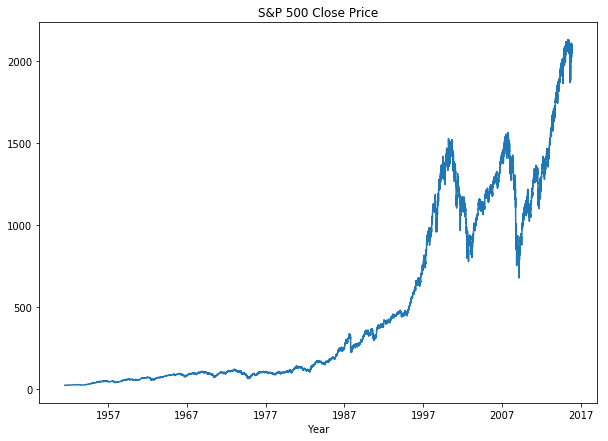

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(index_prices['Date'], index_prices['Close'])
ax.set(title='S&P 500 Close Price', xlabel='Year')

The mean absolute error (MAE) is roughly 7.2. We can see that MAE increases when we start looking at the metrics from the last three decades. As we can see from the graph above, this may be due to the economy's boom in the last couple of decades.